# In this notebook we fit a SEIR model with hidden states to the Moscow Covid-19 data

In [262]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm

In [263]:
sns.set()
%matplotlib inline

In [264]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
%autoreload 2

In [266]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_on_select_dates_and_k_days_ahead

# Load data

In [267]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])
for column in df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        df[column] = df[column].fillna(df[original_column])

In [268]:
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


# Model

In [269]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= '2020-11-30')]

In [270]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [271]:
train_subset.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


In [276]:
class SEIRHiddenMoscow(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
#         params['epidemic_started_days_ago'].value = 20
        return params
    
class HiddenCurveFitterMoscow(HiddenCurveFitter):
    def __init__(self, *args,
                 new_recoveries_col='recovered_per_day',
                 weights=None,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.new_recoveries_col = new_recoveries_col
        self.weights = weights
        
    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(t_vals, initial_conditions, history=True)
        (new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)
        true_daily_cases = data[self.new_cases_col][:len(new_infected_visible)].values
        true_daily_deaths = data[self.new_deaths_col][:len(new_dead_visible)].values
        true_daily_recoveries = data[self.new_recoveries_col][:len(new_recovered_visible)].values

        resid_I_new = self.resid_transform(true_daily_cases, new_infected_visible)
        resid_D_new = self.resid_transform(true_daily_deaths, new_dead_visible)
        resid_R_new = self.resid_transform(true_daily_recoveries, new_recovered_visible)
                
        if self.weights:
            residuals = np.concatenate([
                self.weights['I'] * resid_I_new,
                self.weights['D'] * resid_D_new,
                self.weights['R'] * resid_R_new,
            ]).flatten()
        else:
            residuals = np.concatenate([
                resid_I_new,
                resid_D_new,
                resid_R_new,
            ]).flatten()
        return residuals


In [277]:
stepwize_size = 60

weights = {
    'I': 0.5,
    'R': 0.5,
    'D': 1,
}
model = SEIRHiddenMoscow(stepwise_size=stepwize_size)
fitter = HiddenCurveFitterMoscow(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

In [278]:
result = fitter.result
result

In [279]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

Incubation period: 2.03
Infectious period: 9.00


In [280]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

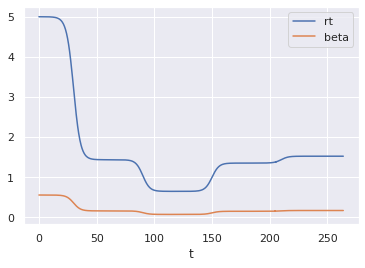

In [281]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

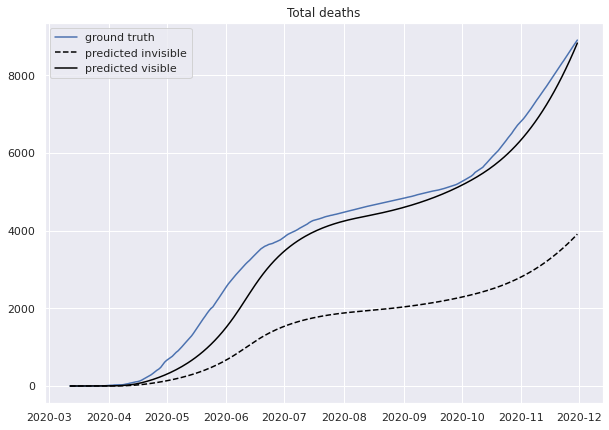

In [282]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

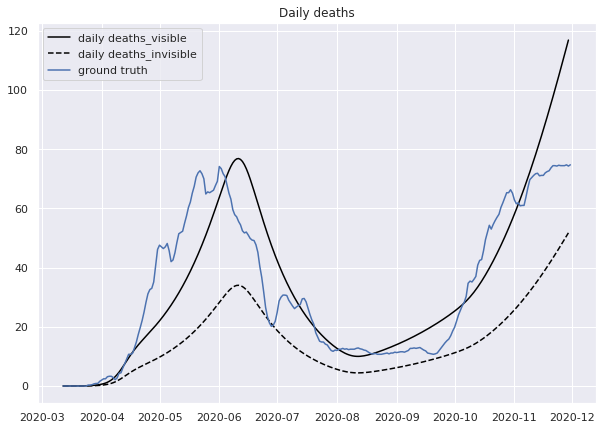

In [283]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['deaths_per_day_ma7'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

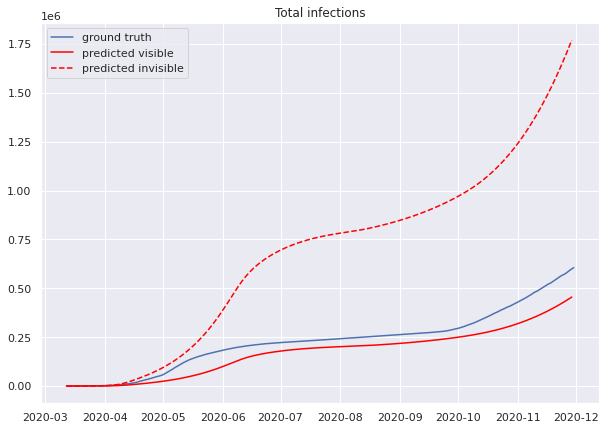

In [284]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='ground truth')
plt.plot(train_subset.date[:-1], new_infected_visible.cumsum(), label='predicted visible', color='red')
plt.plot(train_subset.date[:-1], new_infected_invisible.cumsum(), label='predicted invisible', color='red',  linestyle='dashed' )
plt.legend()
plt.title('Total infections')
plt.show()

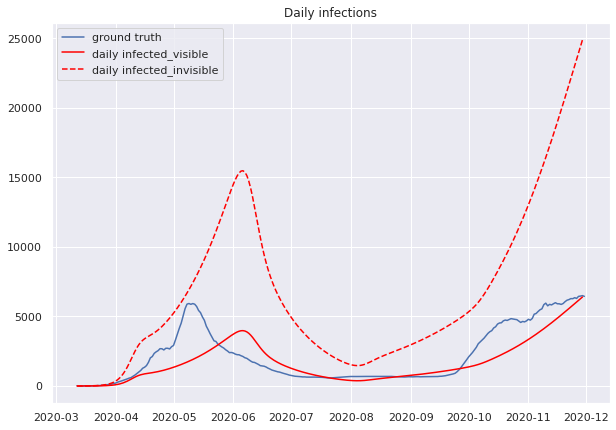

In [285]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day_ma7'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

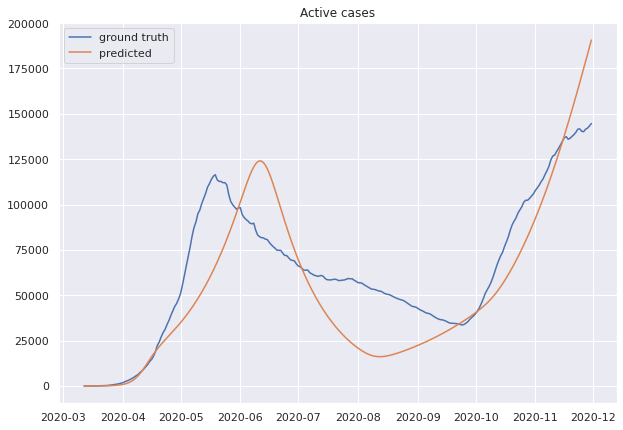

In [286]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Obtain forecast

In [287]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [288]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [289]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [290]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [291]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

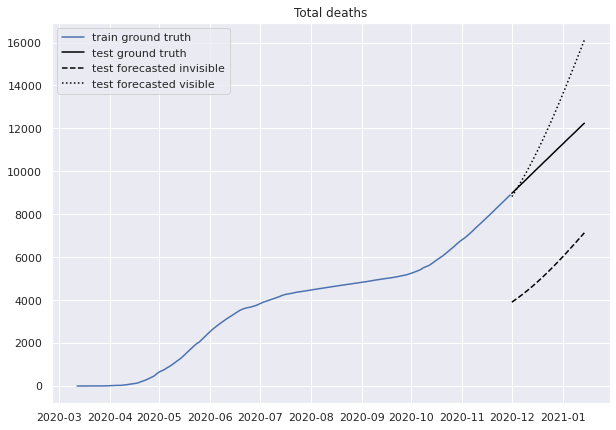

In [292]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='black')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

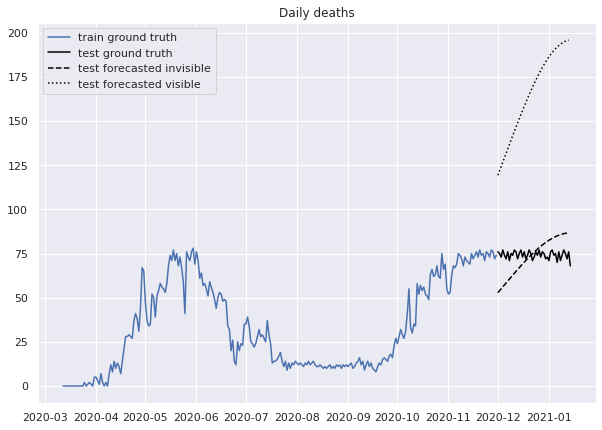

In [293]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

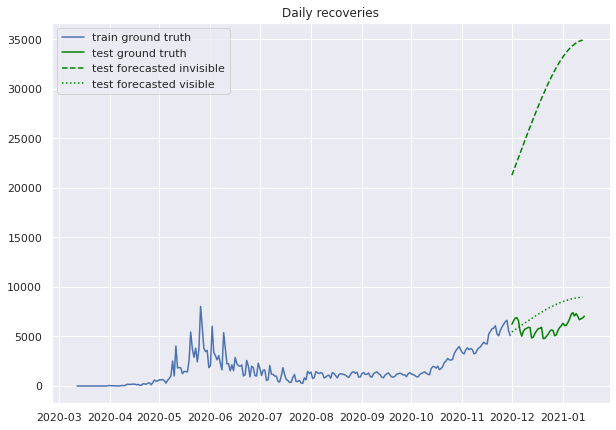

In [294]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_subset.date[:-1], test_new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

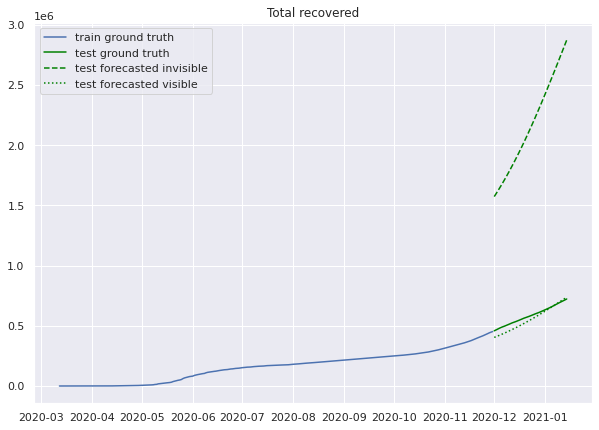

In [295]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='train ground truth')
plt.plot(test_subset.date, test_subset['total_recovered'], label='test ground truth', color='green')
plt.plot(test_subset.date, test_R, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date, test_Rv, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Total recovered')
plt.show()

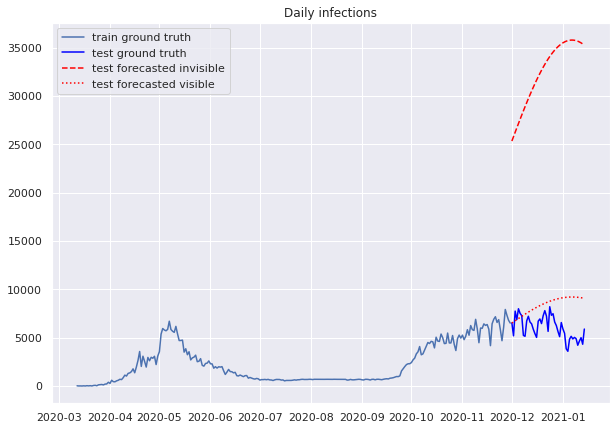

In [296]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['infected_per_day'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# Eval 30 days ahead on fixed dates

In [297]:
K = 30

In [298]:
# Regions where Rt does not jump much
eval_dates = pd.date_range(start='2020-06-01', end='2020-09-01')[::3]
eval_dates[:10], len(eval_dates)

(DatetimeIndex(['2020-06-01', '2020-06-04', '2020-06-07', '2020-06-10',
                '2020-06-13', '2020-06-16', '2020-06-19', '2020-06-22',
                '2020-06-25', '2020-06-28'],
               dtype='datetime64[ns]', freq='3D'),
 31)

In [304]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.5,
        'R': 0.5,
        'D': 1,
    }
    stepwise_size=30
    model = SEIRHiddenMoscow(stepwise_size=stepwise_size)
    fitter = HiddenCurveFitterMoscow(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [305]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

In [306]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [307]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [308]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [309]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline).round(3))
print('Mean point 7 days ahead error model', np.mean(point_errors_model).round(3))

Mean overall error baseline 326.699
Mean overall error model 118.6
Mean point 7 days ahead error baseline 579.323
Mean point 7 days ahead error model 230.766


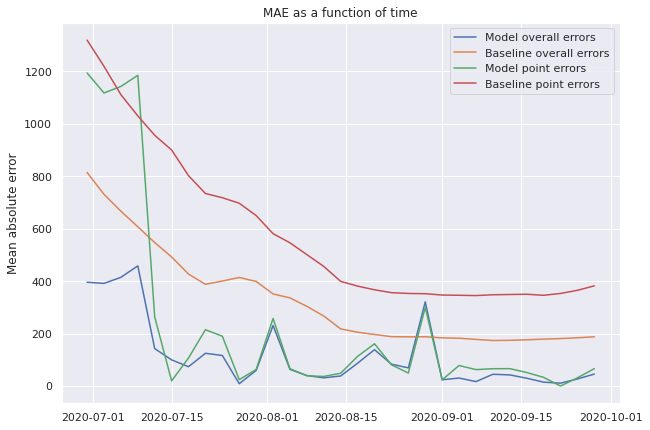

In [310]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.title('MAE as a function of time')
plt.show()

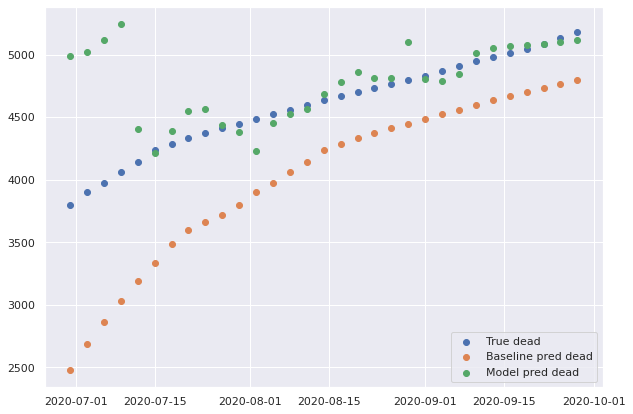

In [311]:
plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()

### Take a look on one prediction

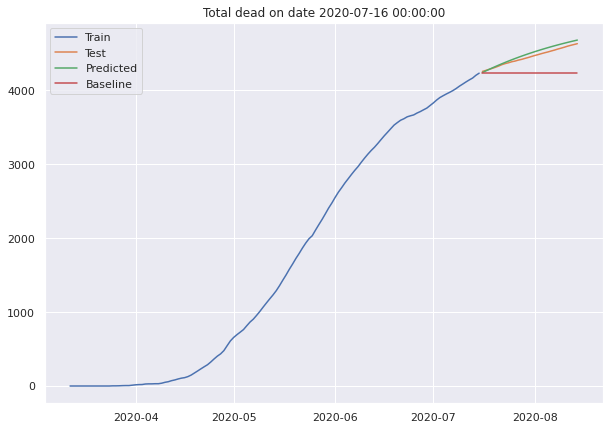

In [312]:
train_df = train_dfs[15]
test_df = test_dfs[15]
model_preds = model_predictions[15]
baseline_predictions = baseline_pred_D[15]
fitter = fitters[15]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [313]:
fitter.result